In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('bankex.csv', index_col=['date'])
prices.head(10)

HDFCBANK.NS  ICICIBANK.NS  KOTAKBANK.NS  AXISBANK.NS     SBIN.NS  \
date                                                                           
01-01-2018   927.250000    310.299988    999.950012   565.500000  307.100006   
02-01-2018   936.174988    309.700012   1003.200012   559.500000  303.250000   
03-01-2018   926.325012    315.000000   1000.099976   560.450012  302.850006   
04-01-2018   929.950012    314.700012   1000.400024   559.900024  308.500000   
05-01-2018   931.799988    312.899994   1003.049988   563.250000  306.350006   
08-01-2018   930.299988    314.149994   1006.099976   565.450012  305.799988   
09-01-2018   931.849976    312.600006   1009.750000   565.299988  304.299988   
10-01-2018   932.099976    312.000000   1002.250000   562.799988  301.100006   
11-01-2018   936.275024    309.500000   1017.650024   558.750000  302.200012   
12-01-2018   932.650024    317.700012   1023.349976   555.099976  302.250000   

            INDUSINDBK.NS  FEDERALBNK.NS  IDFCFIRSTB.NS   AUBANK.NS  
date                                                                 
01-01-2018    1623.849976     108.699997      54.849998  662.849976  
02-01-2018    1643.949951     107.599998      53.950001  661.400024  
03-01-2018    1630.250000     107.699997      54.150002  669.750000  
04-01-2018    1646.599976     108.650002      54.549999  675.000000  
05-01-2018    1698.199951     112.099998      58.250000  699.450012  
08-01-2018    1719.900024     115.550003      63.349998  712.000000  
09-01-2018    1725.050049     115.150002      62.799999  699.400024  
10-01-2018    1734.099976     113.150002      63.250000  699.549988  
11-01-2018    1700.300049     114.000000      68.550003  709.549988  
12-01-2018    1705.250000     115.050003      67.500000  705.200012

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

HDFCBANK.NS  ICICIBANK.NS  KOTAKBANK.NS  AXISBANK.NS     SBIN.NS  \
date                                                                           
01-01-2018   927.250000    310.299988    999.950012   565.500000  307.100006   
02-01-2018   936.174988    309.700012   1003.200012   559.500000  303.250000   
30-12-2020  1432.500000    528.750000   2017.949951   625.099976  276.899994   
31-12-2020  1436.300049    535.049988   1995.599976   620.450012  274.950012   

            INDUSINDBK.NS  FEDERALBNK.NS  IDFCFIRSTB.NS   AUBANK.NS  
date                                                                 
01-01-2018    1623.849976     108.699997      54.849998  662.849976  
02-01-2018    1643.949951     107.599998      53.950001  661.400024  
30-12-2020     899.049988      67.250000      36.650002  852.450012  
31-12-2020     894.950012      66.699997      37.049999  852.599976

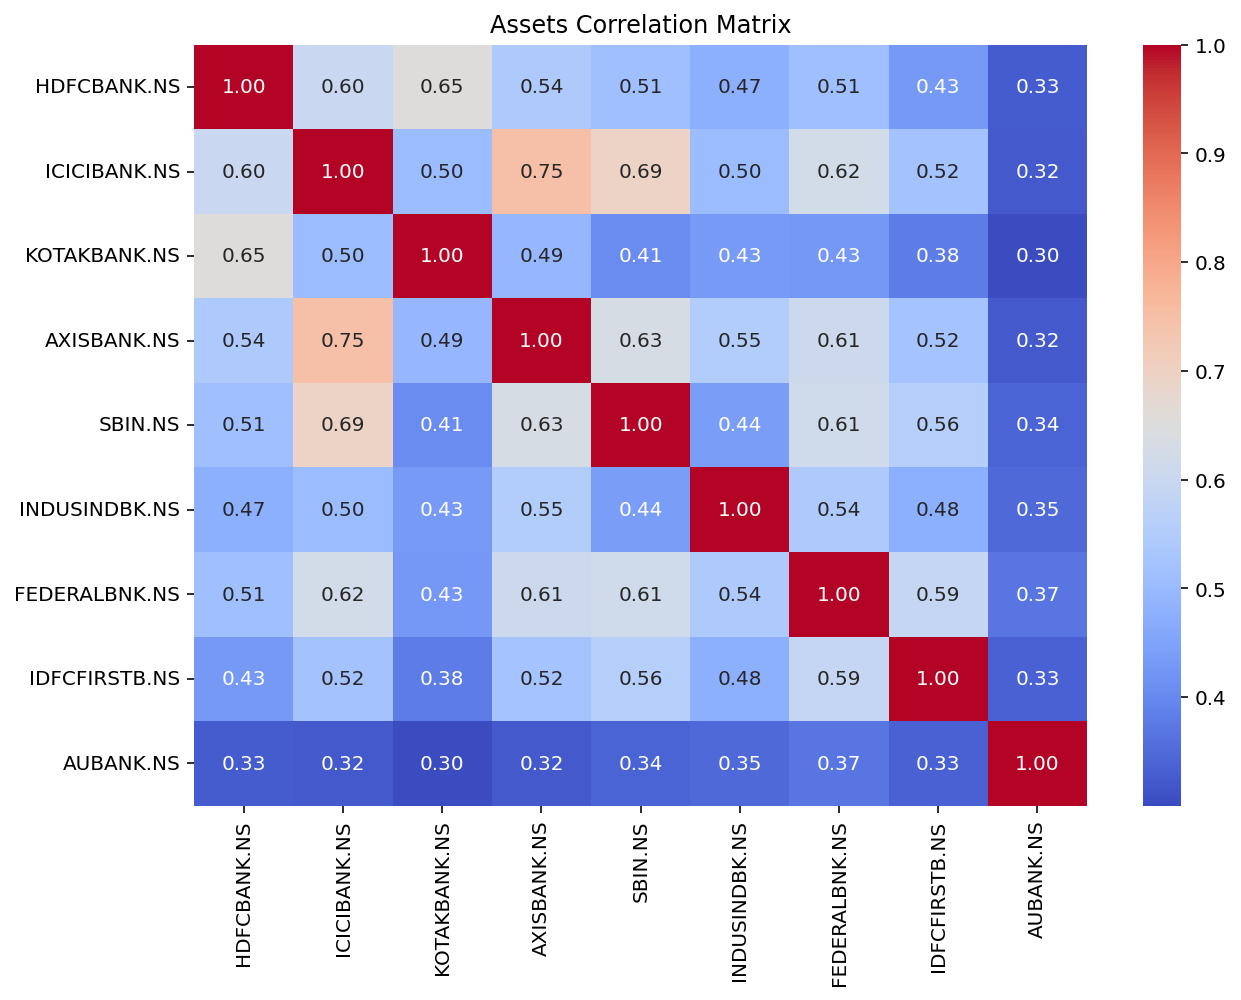

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('HDFCBANK.NS', 'KOTAKBANK.NS'), ('AXISBANK.NS', 'SBIN.NS'), ('FEDERALBNK.NS', 'IDFCFIRSTB.NS')]


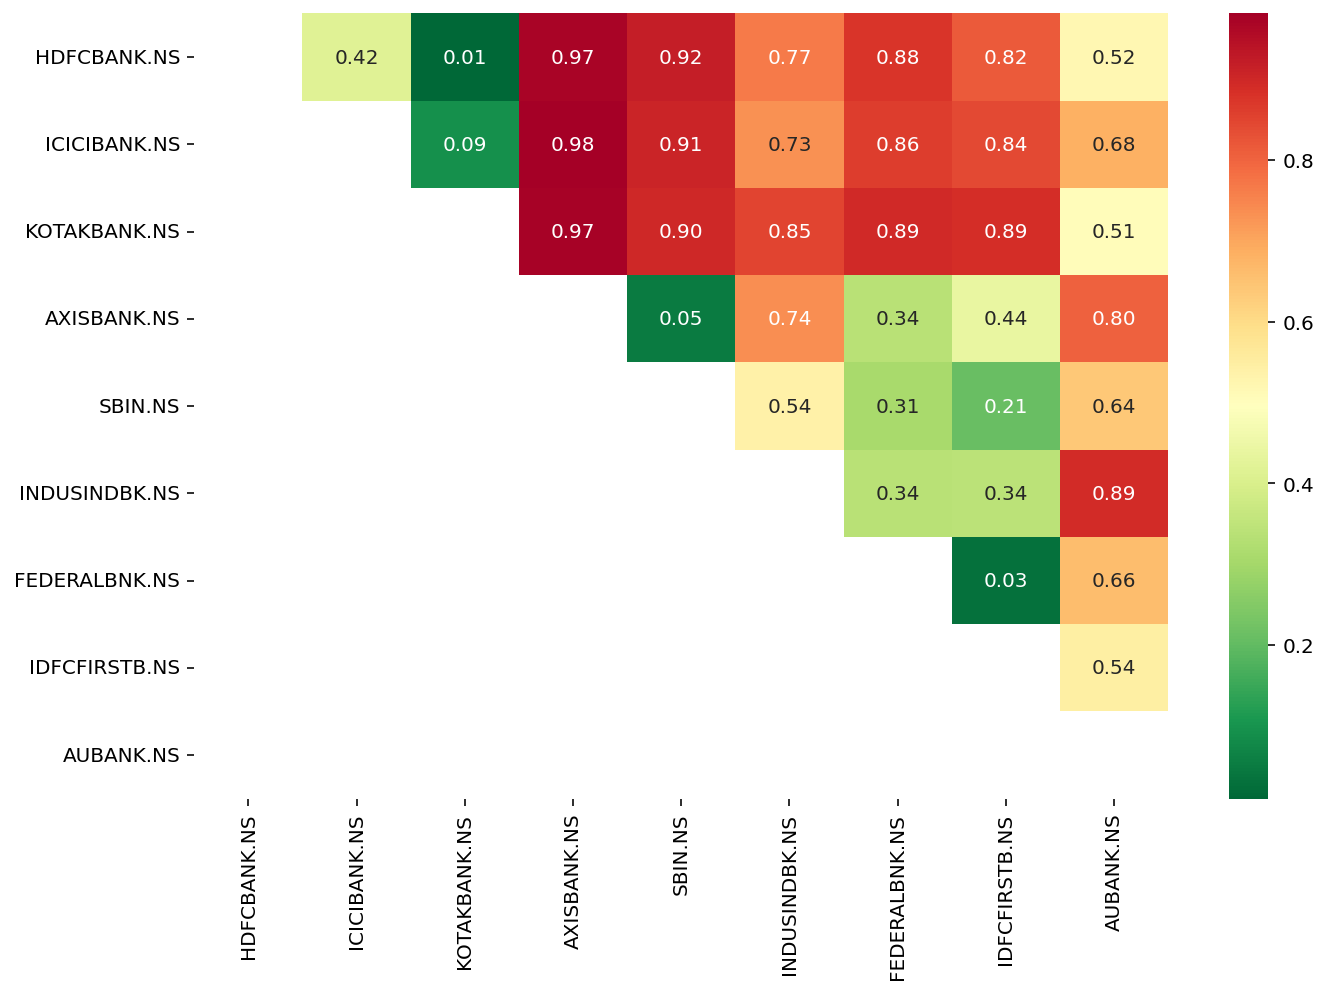

In [8]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
#ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=500) 

### Perform a Cointegration test for the Selected Pair

In [10]:
# final pair to test strategy
asset1 = 'SBIN.NS'
asset2 = 'IDFCFIRSTB.NS'

In [11]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

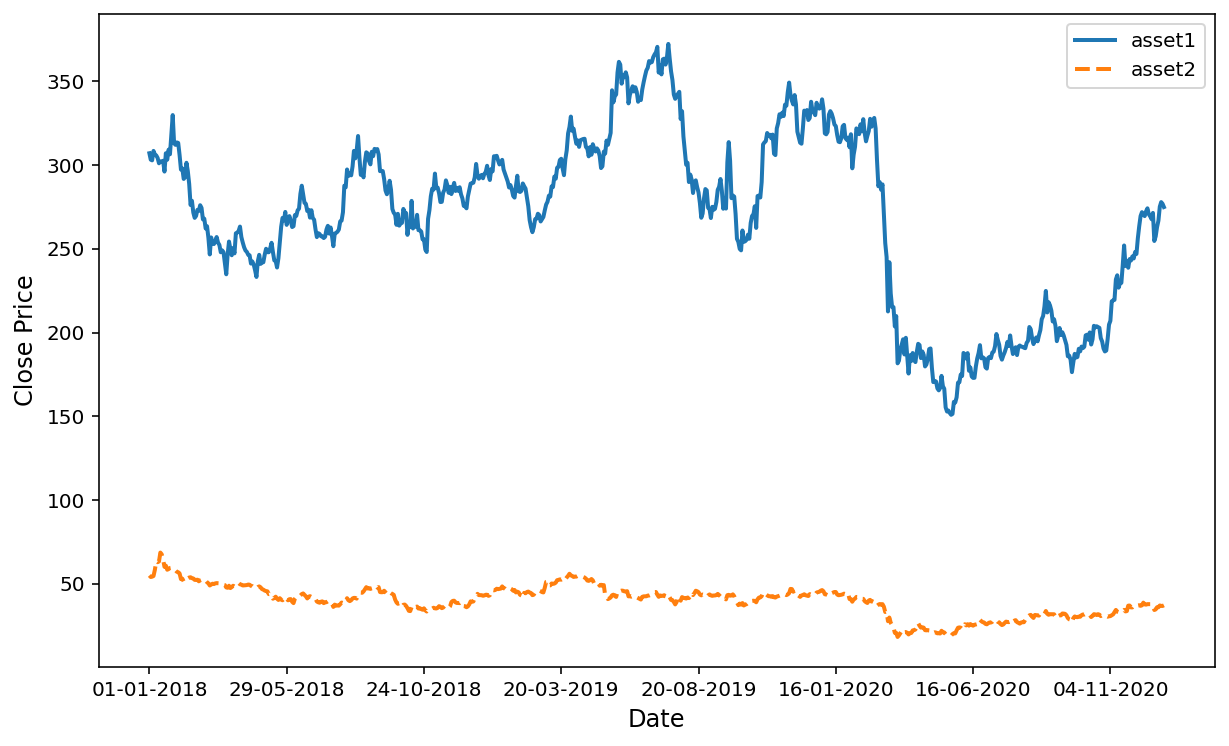

In [12]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1']].plot(figsize=(10, 6), linewidth=2,linestyle='solid', label = "asset1")
plt.plot(train[['asset2']], linewidth=2, linestyle='dashed', label = "asset2")
ax.set_ylabel("Close Price", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
plt.legend()
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
#ax.grid(True);
plt.savefig('chart3', dpi=500) 

In [13]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          3.212e+04
Date:                Thu, 12 May 2022   Prob (F-statistic):                        0.00
Time:                        13:43:26   Log-Likelihood:                         -2392.7
No. Observations:                 740   AIC:                                      4787.
Df Residuals:                     739   BIC:                                      4792.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.1478      0.001    179.211      0.000       0.146       0.149
==============================================================================
Omnibus:                       49.370   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.528
Skew:                           0.664   Prob(JB):                     3.22e-13
Kurtosis:                       3.318   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

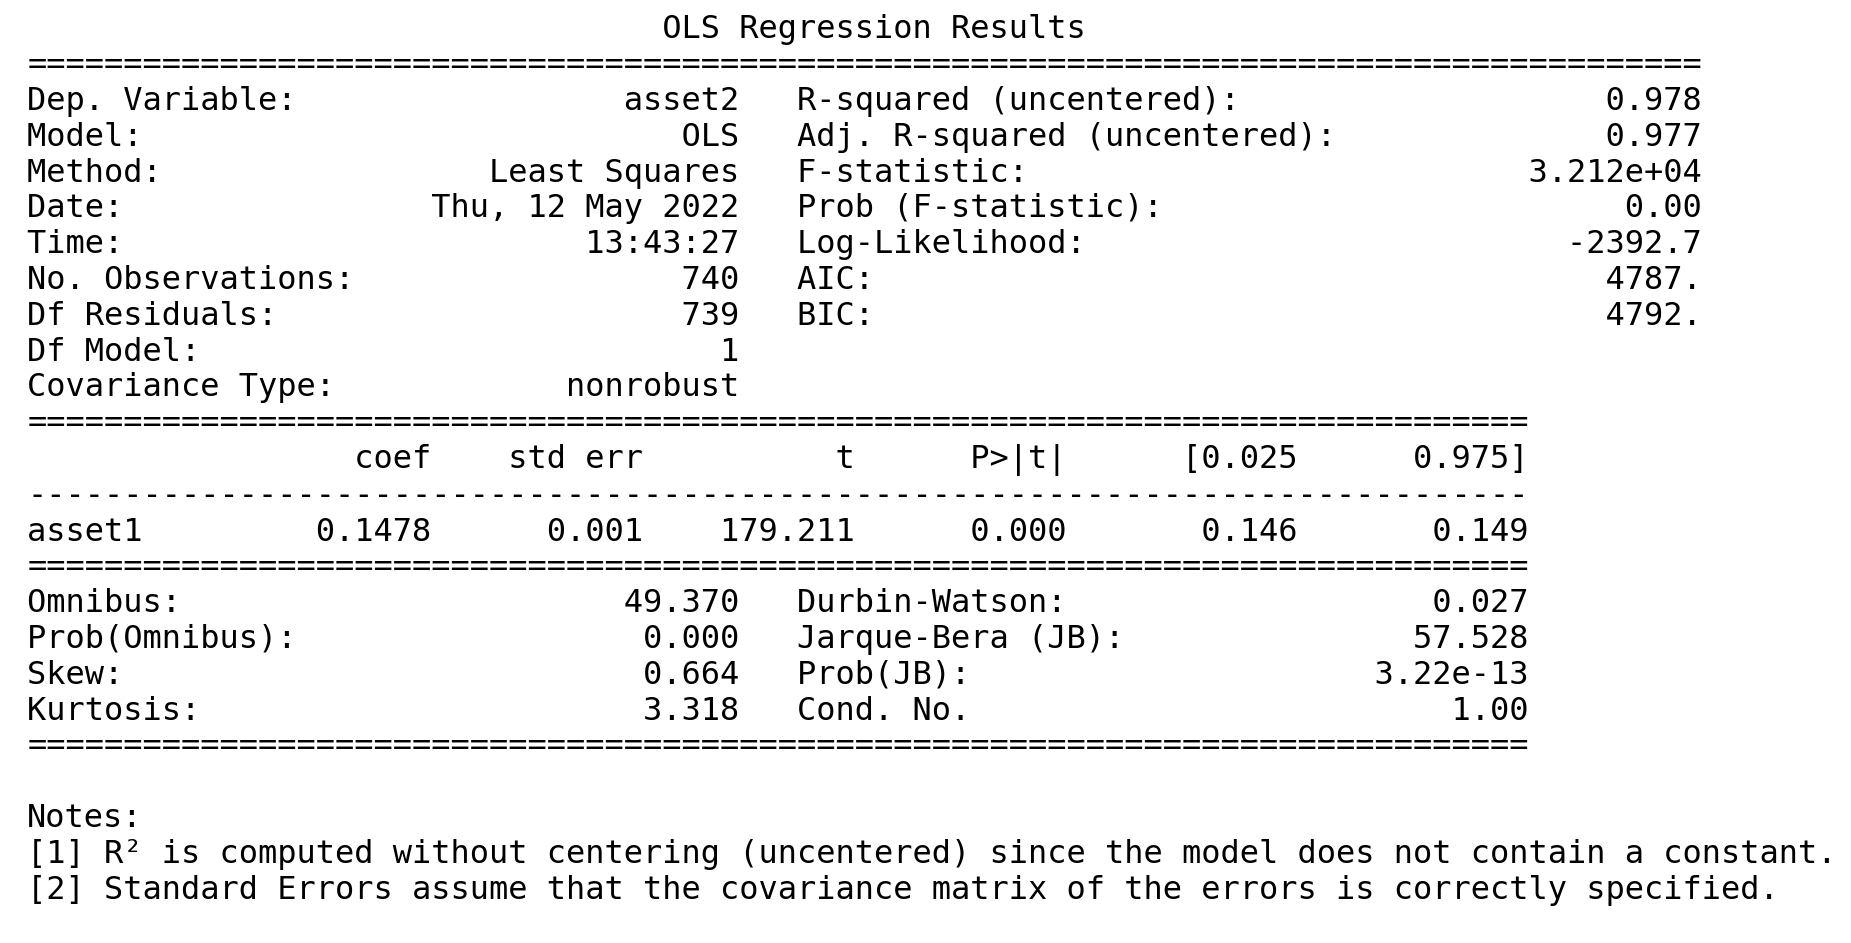

In [15]:
# print regression summary results
plt.rc('figure', figsize=(15, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [16]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.1478268806920888


In [19]:
# calculate spread
residual = train.asset2 - model.params[0] * train.asset1

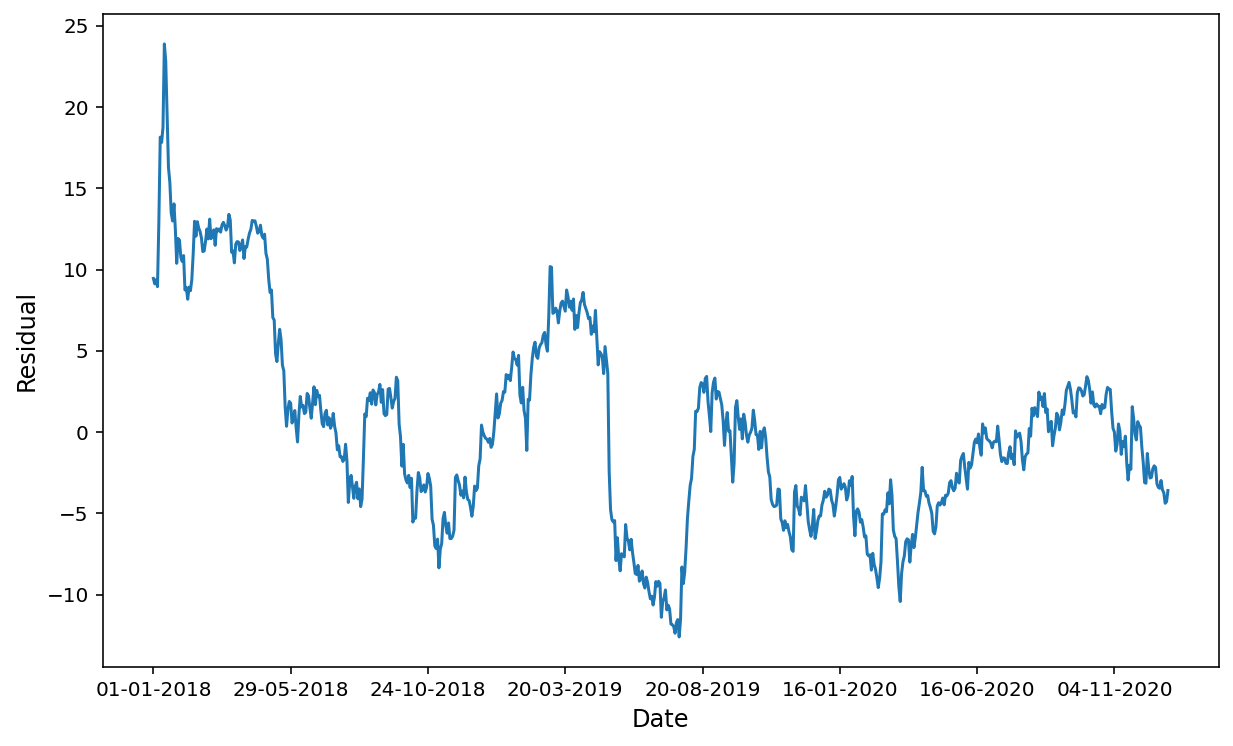

In [20]:
# Plot the residual
ax = residual.plot(figsize=(10, 6))
ax.set_ylabel("Residual", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
# ax.grid(True);
plt.savefig('chart5', dpi=500);

In [21]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-2.5565829515887044,
 0.10230674329080941,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 2098.566854583049)

In [22]:
print('Critical Value = ', adf[0])

Critical Value =  -2.5565829515887044


In [23]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [24]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [25]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [26]:
signals.head()

asset1     asset2
date                             
01-01-2021  279.399994  37.400002
04-01-2021  281.049988  38.599998
05-01-2021  281.750000  39.700001
06-01-2021  285.049988  41.400002
07-01-2021  287.700012  45.799999

In [27]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [28]:
signals.head()

asset1     asset2         z  z upper limit  z lower limit
date                                                                     
01-01-2021  279.399994  37.400002 -0.398414            1.0           -1.0
04-01-2021  281.049988  38.599998 -0.522874            1.0           -1.0
05-01-2021  281.750000  39.700001 -0.643794            1.0           -1.0
06-01-2021  285.049988  41.400002 -0.782842            1.0           -1.0
07-01-2021  287.700012  45.799999 -1.179278            1.0           -1.0

In [29]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [30]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

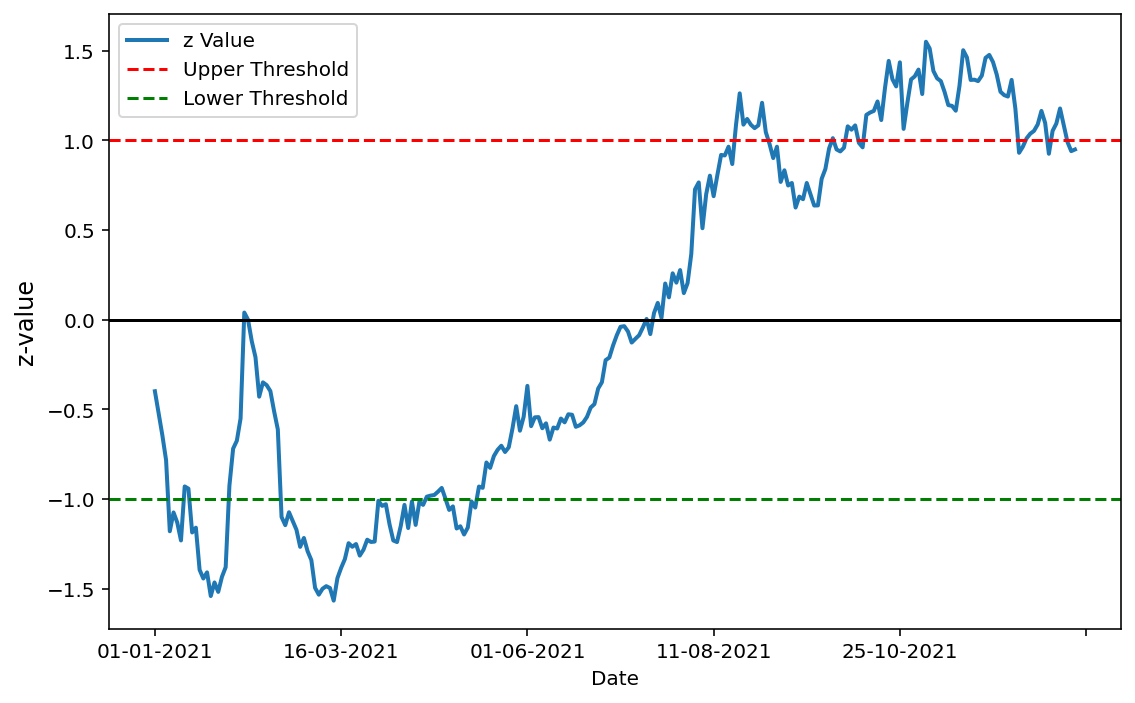

In [34]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value", figsize=(8, 5), linewidth=2)
#plt.title("Z-score Evaluation")
plt.ylabel("z-value", fontsize=12)
plt.xlabel("Date")
plt.axhline(signals['z'].mean(),linestyle= 'solid', color="black")
plt.axhline(signals['z upper limit'].mean(), linestyle= 'dashed',color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), linestyle = 'dashed', color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=500);

In [35]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  279.399994  37.400002 -0.398414            1.0           -1.0   
04-01-2021  281.049988  38.599998 -0.522874            1.0           -1.0   
05-01-2021  281.750000  39.700001 -0.643794            1.0           -1.0   
29-12-2021  454.399994  47.400002  0.991274            1.0           -1.0   
30-12-2021  451.700012  47.500000  0.940686            1.0           -1.0   
31-12-2021  460.450012  48.349998  0.949746            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
29-12-2021         0         1.0         0        -1.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [36]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                        
07-01-2021  287.700012  45.799999 -1.179278            1.0           -1.0   
08-01-2021  286.000000  44.400002 -1.074337            1.0           -1.0   
11-01-2021  282.500000  44.450001 -1.130811            1.0           -1.0   
12-01-2021  292.500000  47.150002 -1.230543            1.0           -1.0   
15-01-2021  303.850006  48.450001 -1.186008            1.0           -1.0   
18-01-2021  294.450012  46.650002 -1.159419            1.0           -1.0   
19-01-2021  298.600006  50.150002 -1.394388            1.0           -1.0   
20-01-2021  302.549988  51.450001 -1.442774            1.0           -1.0   
21-01-2021  294.850006  49.700001 -1.408537            1.0           -1.0   
22-01-2021  283.700012  49.500000 -1.540735            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
07-01-2021         1         1.0        -1        -1.0  
08-01-2021         1         0.0        -1         0.0  
11-01-2021         1         0.0        -1         0.0  
12-01-2021         1         0.0        -1         0.0  
15-01-2021         1         1.0        -1        -1.0  
18-01-2021         1         0.0        -1         0.0  
19-01-2021         1         0.0        -1         0.0  
20-01-2021         1         0.0        -1         0.0  
21-01-2021         1         0.0        -1         0.0  
22-01-2021         1         0.0        -1         0.0

In [37]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  279.399994  37.400002 -0.398414            1.0           -1.0   
07-01-2021  287.700012  45.799999 -1.179278            1.0           -1.0   
13-01-2021  306.799988  46.049999 -0.929266            1.0           -1.0   
15-01-2021  303.850006  48.450001 -1.186008            1.0           -1.0   
01-02-2021  310.700012  46.599998 -0.925943            1.0           -1.0   
10-12-2021  494.700012  52.099998  0.931313            1.0           -1.0   
14-12-2021  488.549988  50.799999  1.011390            1.0           -1.0   
22-12-2021  455.850006  48.049999  0.925921            1.0           -1.0   
23-12-2021  461.799988  47.700001  1.053565            1.0           -1.0   
29-12-2021  454.399994  47.400002  0.991274            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
07-01-2021         1         1.0        -1        -1.0  
13-01-2021         0        -1.0         0         1.0  
15-01-2021         1         1.0        -1        -1.0  
01-02-2021         0        -1.0         0         1.0  
10-12-2021         0         1.0         0        -1.0  
14-12-2021        -1        -1.0         1         1.0  
22-12-2021         0         1.0         0        -1.0  
23-12-2021        -1        -1.0         1         1.0  
29-12-2021         0         1.0         0        -1.0

In [38]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

287.700012    1
303.850006    1
399.549988    1
353.500000    1
429.750000    1
460.000000    1
457.899994    1
494.700012    1
455.850006    1
454.399994    1
Name: asset1, dtype: int64

In [39]:
signals

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  279.399994  37.400002 -0.398414            1.0           -1.0   
04-01-2021  281.049988  38.599998 -0.522874            1.0           -1.0   
05-01-2021  281.750000  39.700001 -0.643794            1.0           -1.0   
06-01-2021  285.049988  41.400002 -0.782842            1.0           -1.0   
07-01-2021  287.700012  45.799999 -1.179278            1.0           -1.0   
...                ...        ...       ...            ...            ...   
27-12-2021  458.049988  46.400002  1.178633            1.0           -1.0   
28-12-2021  461.200012  47.400002  1.085496            1.0           -1.0   
29-12-2021  454.399994  47.400002  0.991274            1.0           -1.0   
30-12-2021  451.700012  47.500000  0.940686            1.0           -1.0   
31-12-2021  460.450012  48.349998  0.949746            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         1         1.0        -1        -1.0  
...              ...         ...       ...         ...  
27-12-2021        -1         0.0         1         0.0  
28-12-2021        -1         0.0         1         0.0  
29-12-2021         0         1.0         0        -1.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [40]:
signals = signals.reset_index()

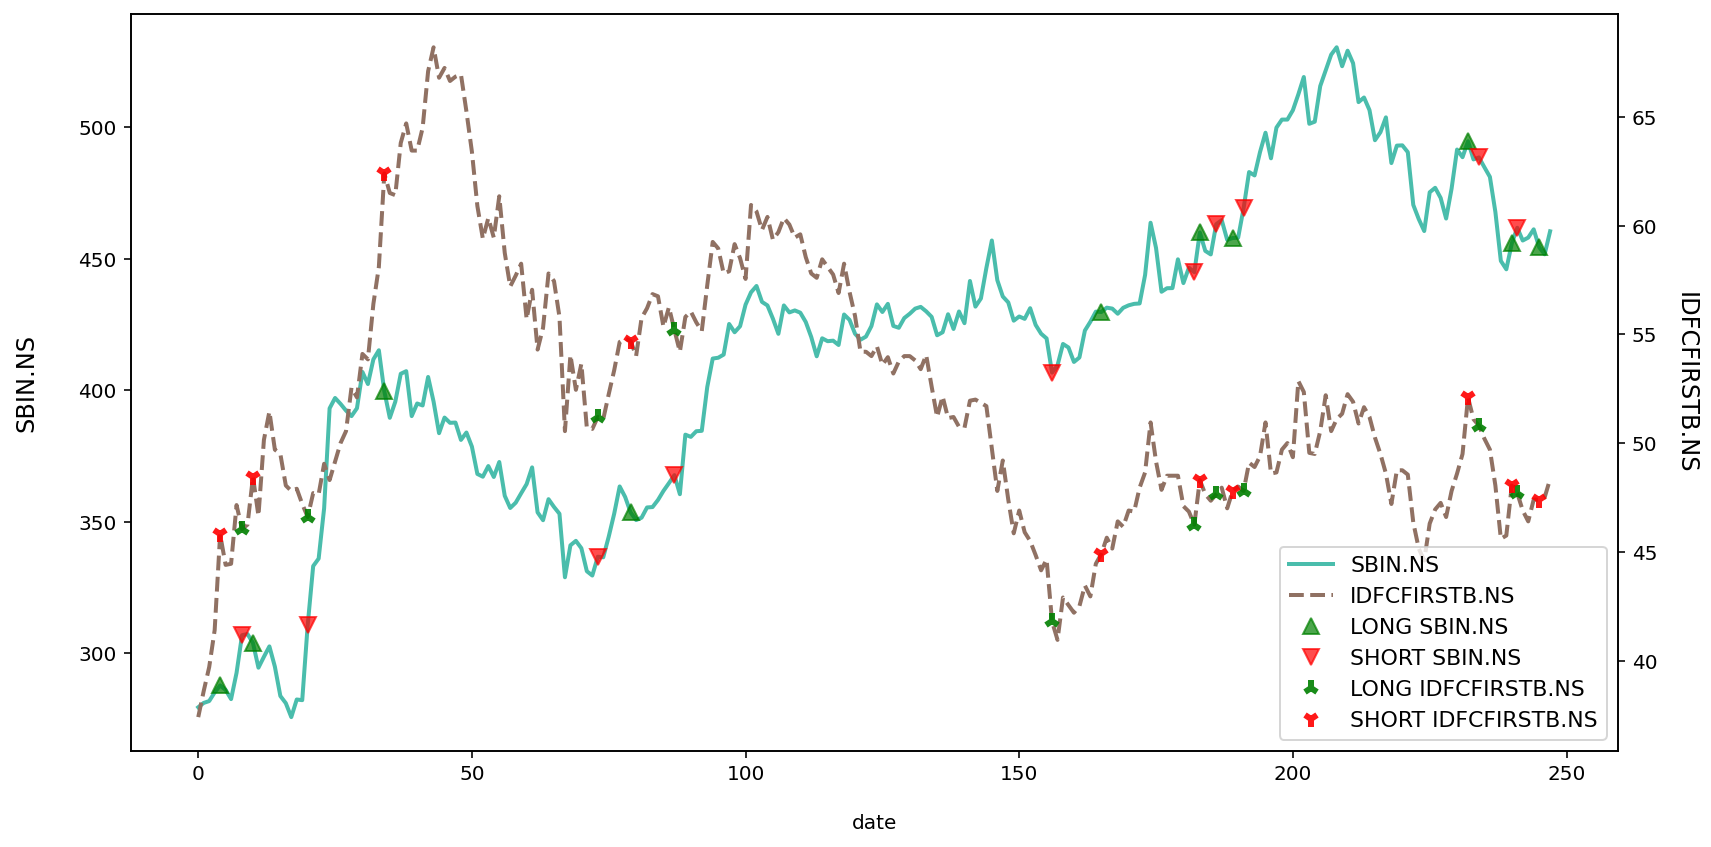

In [49]:
# visualize trading signals and position
fig=plt.figure(figsize=(12,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac', linestyle = 'solid', linewidth=2)
l2, = bx2.plot(signals['asset2'], c='#907163', linestyle = 'dashed', linewidth=2)

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, 
              marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,
              marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,
               marker='2',markersize=8, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,
               marker='1',markersize=8, c='r',alpha=0.9,markeredgewidth=3)
bx.set_ylabel(asset1,fontsize=12)
bx2.set_ylabel(asset2, rotation=270, fontsize=12)
bx.yaxis.labelpad=20
bx2.yaxis.labelpad=20
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='lower right', fontsize = 11)

#plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date', fontsize=12)
#plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=500);

### Portfolio Profit and Loss Calculation

In [50]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [51]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [52]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    279.399994           NaN            NaN            NaN       NaN   
1    281.049988      0.000000  100000.000000  100000.000000       NaN   
2    281.750000      0.000000  100000.000000  100000.000000  0.000000   
3    285.049988      0.000000  100000.000000  100000.000000  0.000000   
4    287.700012  54087.602294   45912.397706  100000.000000  0.000000   
243  458.049988 -86113.397706  177719.193119   91605.795413 -0.002252   
244  461.200012 -86705.602294  177719.193119   91013.590826 -0.006465   
245  454.399994      0.000000   92291.994266   92291.994266  0.014046   
246  451.700012      0.000000   92291.994266   92291.994266  0.000000   
247  460.450012      0.000000   92291.994266   92291.994266  0.000000   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           1.0  
243         0.0  
244         0.0  
245         1.0  
246         0.0  
247         0.0

In [53]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   279.399994           NaN            NaN            NaN       NaN   
4   287.700012  54087.602294   45912.397706  100000.000000  0.000000   
8   306.799988      0.000000  103590.795413  103590.795413  0.026644   
10  303.850006  57123.801147   46466.994266  103590.795413  0.000000   
20  310.700012      0.000000  104878.596560  104878.596560  0.054037   

    positions1  
0          NaN  
4          1.0  
8         -1.0  
10         1.0  
20        -1.0

In [54]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [55]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    279.399994           NaN            NaN            NaN       NaN   
1    281.049988      0.000000  100000.000000  100000.000000       NaN   
2    281.750000      0.000000  100000.000000  100000.000000  0.000000   
3    285.049988      0.000000  100000.000000  100000.000000  0.000000   
4    287.700012  54087.602294   45912.397706  100000.000000  0.000000   
243  458.049988 -86113.397706  177719.193119   91605.795413 -0.002252   
244  461.200012 -86705.602294  177719.193119   91013.590826 -0.006465   
245  454.399994      0.000000   92291.994266   92291.994266  0.014046   
246  451.700012      0.000000   92291.994266   92291.994266  0.000000   
247  460.450012      0.000000   92291.994266   92291.994266  0.000000   

     positions1     asset2     holdings2          cash2   total asset2  \
0           NaN  37.400002           NaN            NaN            NaN   
1           0.0  38.599998      0.000000  100000.000000  100000.000000   
2           0.0  39.700001      0.000000  100000.000000  100000.000000   
3           0.0  41.400002      0.000000  100000.000000  100000.000000   
4           1.0  45.799999 -67142.798886  167142.798886  100000.000000   
243         0.0  46.400002  68022.402243   58145.701129  126168.103372   
244         0.0  47.400002  69488.402243   58145.701129  127634.103372   
245         1.0  47.400002      0.000000  127634.103372  127634.103372   
246         0.0  47.500000      0.000000  127634.103372  127634.103372   
247         0.0  48.349998      0.000000  127634.103372  127634.103372   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000        -1.0  
243 -0.005776         0.0  
244  0.011619         0.0  
245  0.000000        -1.0  
246  0.000000         0.0  
247  0.000000         0.0

In [56]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   279.399994           NaN            NaN            NaN       NaN   
4   287.700012  54087.602294   45912.397706  100000.000000  0.000000   
8   306.799988      0.000000  103590.795413  103590.795413  0.026644   
10  303.850006  57123.801147   46466.994266  103590.795413  0.000000   
20  310.700012      0.000000  104878.596560  104878.596560  0.054037   

    positions1     asset2     holdings2          cash2   total asset2  \
0          NaN  37.400002           NaN            NaN            NaN   
4          1.0  45.799999 -67142.798886  167142.798886  100000.000000   
8         -1.0  46.049999      0.000000   99633.500000   99633.500000   
10         1.0  48.450001 -71027.701114  170661.201114   99633.500000   
20        -1.0  46.599998      0.000000  102345.603357  102345.603357   

     return2  positions2  
0        NaN         NaN  
4   0.000000        -1.0  
8   0.016452         1.0  
10  0.000000        -1.0  
20  0.008669         1.0

In [57]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

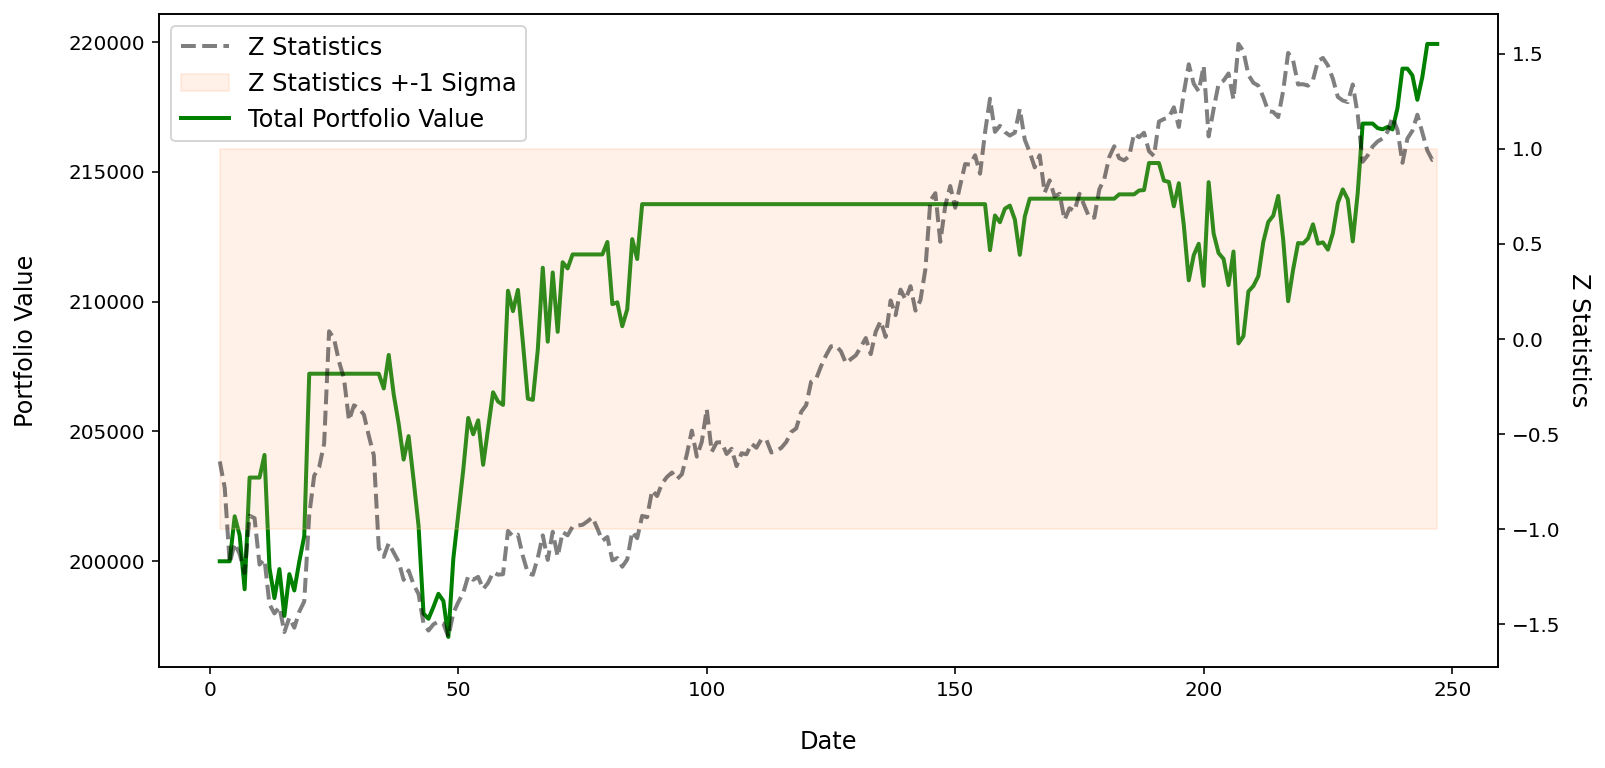

In [60]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(12,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g', linewidth = 2, linestyle='solid')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.5, linewidth = 2, 
               linestyle='dashed')

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value', fontsize=12)
ax2.set_ylabel('Z Statistics',rotation=270, fontsize=12)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date', fontsize=12)
ax.xaxis.labelpad=15
#plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left', fontsize=12);
plt.savefig('chart8', dpi=500);

In [59]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

219926.09763779998

In [60]:
profit = final_portfolio - 2*initial_capital
profit

19926.097637799976

In [61]:
roi = (profit / (2*initial_capital))*100
roi

9.963048818899987

In [62]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

Number of days =  245


In [63]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 223.536%
